## Übung 7: Komplementärfilter (Python)

Dieses Python-Skript dient als Vorlage für die Bearbeitung von Übung 7. 

In [73]:
# import necessary libraries
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math

Das folgende Codestück dient als Hauptimplementierung des Komplementärfilters. Alle anderen Funktionen werden hier aufgerufen, müssen aber in den zugewiesenen Zellen implementiert werden. Die Funktionszellen müssen ausgeführt werden, bevor sie aufgeruft werden können. 

In [85]:
# complementary filter

# loads the data
# Accelerometer, Magnetometer und Gyroscope for 3 Axis IMU + time +
# computed euler angles with KF for comparison
file = sio.loadmat('lrlaborEX7.mat')
Accelerometer = file['Accelerometer']
Gyroscope = file['Gyroscope']
Magnetometer = file['Magnetometer']
euler = file['euler']
time = file['time']

# Plot the raw measurements
# fig, ax = plt.subplots(3,1, figsize=(10,10))

# ax[0].plot(time, Accelerometer[:,0], time, Accelerometer[:,1], time, Accelerometer[:,2])
# ax[0].legend(['x-acc.','y-acc.','z-acc.'])
# ax[0].set_xlabel('Time [s]')
# ax[0].set_ylabel('Accelerometer readings [m/s²]')
    
# ax[1].plot(time, Gyroscope[:,0], time, Gyroscope[:,1], time, Gyroscope[:,2])
# ax[1].legend(['x-angvel','y-angvel','z-angvel'])
# ax[1].set_xlabel('Time [s]')
# ax[1].set_ylabel('Gyroscope readings [rad/s?]')

# ax[2].plot(time, Magnetometer[:,0], time, Magnetometer[:,1], time, Magnetometer[:,2])
# ax[2].legend(['x-mag.','y-mag.','z-mag.'])
# ax[2].set_xlabel('Time [s]')
# ax[2].set_ylabel('Magnetometer readings [μT?]')

# for axes in ax:
#     axes.grid(True)
    
# Task 1a
freq = []
delt_t = []

for i in range(1,len(time)):
    freq.append(float((1/(time[i]- time[i-1]))))
    delt_t.append(float(((time[i]- time[i-1]))))
freq.append(freq[-1])
delt_t.append(delt_t[-1])
  
# plt.plot(time, freq)
# plt.xlabel('Time [s]')
# plt.ylabel('Data rate [Hz]')
# plt.grid()
# plt.show

ave_freq = sum(freq)/len(freq)
print('Avergae data rate: ' + str(ave_freq))

# Implement the complimentary filter
initSamples = 0;                        # TODO Task 1c)
beta =  1;                              # TODO Task 1d)

rpy = np.zeros((len(time),3));

gyro_bias = calcGyroBias(6000, Gyroscope)        # TODO: Task 1c) determine gyro bias
# subtract bias from measured gyro ang vel to get real ang vel (assume white noise 0?)
gyro = np.zeros((len(time),3));
for j in range(0, len(rpy)-1):
    gyro[j, 0] = Gyroscope[j, 0] - gyro_bias[0]
    gyro[j, 1] = Gyroscope[j, 1] - gyro_bias[1]
    gyro[j, 2] = Gyroscope[j, 2] - gyro_bias[2]

rpy_init = updateAcc(Accelerometer[0,:])
rpy[initSamples,0] = rpy_init[0]  # TODO: Task 1d) determine initial state of filter
rpy[initSamples,1] = rpy_init[1]
rpy[initSamples,2] = updateMag(Magnetometer[0,:], rpy_init)

for i in range(initSamples+1,len(time)):
    
    # TODO: Update the filter
    rpy_gyro = updateGyro(gyro[i,:], rpy[i-1,:], delt_t[i])
    rpy_acc = updateAcc(Accelerometer[i,:])
    yaw_mag = updateMag(Magnetometer[i,:], rpy[i-1,:])
    
    rpy[i,0] = (1-beta)*(rpy_gyro[0]) + beta*rpy_acc[0]
    rpy[i,1] = (1-beta)*(rpy_gyro[1]) + beta*rpy_acc[1]
    rpy[i,2] = (1-beta)*(rpy_gyro[2]) + beta*yaw_mag
    
    # We want the angles to be between pi and -pi
    if(rpy[i,2] > np.pi):
        rpy[i,2] = -2*np.pi + rpy[i,2]
    elif (rpy[i,2] < -np.pi):
        rpy[i,2] = 2*np.pi + rpy[i,2]



Avergae data rate: 498.64625788837543


Die folgende Zelle soll verwendet werden um die erforderlichen Daten darzustellen.

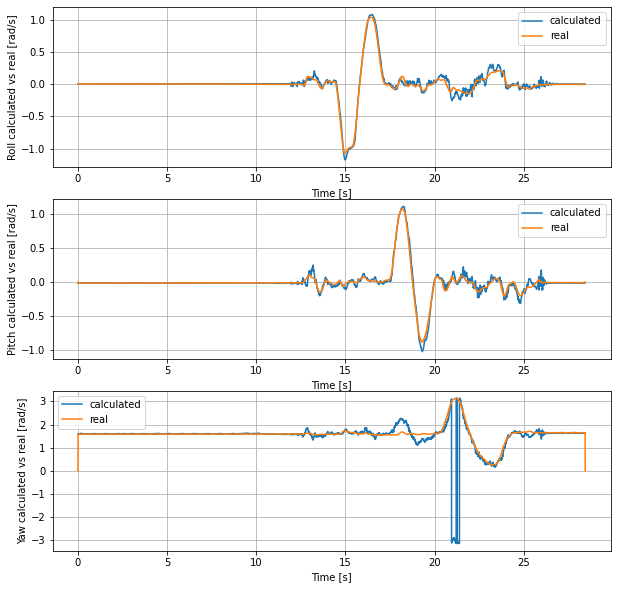

In [87]:
# Plot the data
fig, ax = plt.subplots(3,1, figsize=(10,10))

ax[0].plot(time, rpy[:,0], time, euler[:,0])
ax[0].legend(['calculated','real'])
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Roll calculated vs real [rad/s]')
    
ax[1].plot(time, rpy[:,1], time, euler[:,1])
ax[1].legend(['calculated','real'])
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Pitch calculated vs real [rad/s]')

ax[2].plot(time, rpy[:,2], time, euler[:,2])
ax[2].legend(['calculated','real'])
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('Yaw calculated vs real [rad/s]')

for axes in ax:
    axes.grid(True)

Zur Implementierung des Gyroskop-Filters muss die folgende Funktion verwendet werden. Die Funktion soll dann in der Komplementärfilterzelle aufgeruft werden.

In [81]:
# gyroscope update
def updateGyro(gyro, rpy, dt):
    # UPDATEACC Function for the update step of the Gyroscope
    # Input: The gyro raw measurement + time + current angles 
    # Returns the new euler angles
    rpy_gyro = np.zeros(3)
    
    rpy_gyro[0] = rpy[0] + gyro[0]*dt
    rpy_gyro[1] = rpy[1] + gyro[1]*dt
    rpy_gyro[2] = rpy[2] + gyro[2]*dt

    return rpy_gyro

In [82]:
def calcGyroBias(biasSamples, gyro):
    bias_samples = np.zeros((biasSamples,3));
    bias = np.zeros(3)
    for i in range(0, biasSamples-1):
        bias_samples[i,0] = gyro[i,0]
        bias_samples[i,1] = gyro[i,1]
        bias_samples[i,2] = gyro[i,2]
    bias[0] = (sum(bias_samples[:,0]))/len(bias_samples)
    bias[1] = (sum(bias_samples[:,1]))/len(bias_samples)
    bias[2] = (sum(bias_samples[:,2]))/len(bias_samples)
    
    return bias

Vervollständige die nächste Funktion, damit der Beschleunigungsmesser aktualisiert wird.

In [83]:
# accelerometer update
def updateAcc(acc):
    # UPDATEACC Function for the update step of the Accelerometer
    # Input: Acc raw measurement 
    # Returns the euler angles
    rpy_acc = np.zeros(2);
    
    rpy_acc[0] = math.atan2(acc[1],acc[2])
    rpy_acc[1] = math.atan2(-acc[0],np.sqrt((acc[1])**2 + (acc[2])**2))
        
    return rpy_acc 

Schließlich wird hier die Funktion zur Aktualisierung des Magnetometers abgeschlossen.

In [84]:
# magnetometer update
def updateMag(mag, rpy):
    # UPDATEACC Function for the update step of the Magnetometer
    # Input: The mag raw measurement + current angles
    # Returns yaw
    # TODO remember to rotate mag data :)
    yaw_mag = 0
    
    mx = mag[0]*math.cos(rpy[1]) + mag[1]*math.sin(rpy[1])*math.sin(rpy[0]) + mag[2]*math.sin(rpy[1])*math.cos(rpy[0])
    my = mag[1]*math.cos(rpy[0]) - mag[2]*math.sin(rpy[0])
    yaw_mag = math.atan2(my,-mx)        

    return yaw_mag 

Hier sind einige Zellen, um Notizen zu schreiben oder die theoretischen Fragen zu beantworten :)<br>(Doppelklicke auf die Zelle mit den theoretischen Fragen, um sie zu bearbeiten)

Theoretische Fragen:<br>
1a) Wurden die Daten im Flug aufgezeichnet oder nicht? <br>
1b) Mit welcher Datenrate (in Hz) sollten die Daten vermutlich aufgezeichnet werden, welche durchschnittliche Datenrate wurde erzielt? <br>
    Erzeugen diese Outlier Probleme bei der Filter-Berechnung? Wieso bzw. Wieso nicht? <br>
    Bonus: Was könnte der Grund für die Outlier sein?<br>
1c) Wie viele Messungen sind für den Gyro-bias sinnvoll?<br>
    Was fällt dir auf beim Vergleich der berechneten Euler-Winkel mit den aufgezeichneten Euler-Winkeln? <br>
1d) Wie ändert sich der Filter bei unterschiedlichen Werten von β, welchen Wert hast du gewählt und wieso?